# COMP47670 Assignment 1: Data Collection and Preparation

Name: Oisin Marron

Student Number: 16401562

In [509]:
import os
import pandas as pd
import json
import urllib.request
import csv
import datetime


## Task 1: Identify one or more suitable web APIs
<font color='red'>API Chosen:</font>

I chose a single API for this assignment, provided by www.metaweather.com

This website gives access to its historical worldwide weather API found at- 
https://www.metaweather.com/api/#locationsearch
Here instructions are provided describing how to access the data of a desired location at a desired time.

An example is as follows:
https://www.metaweather.com/api/location/2379574/2020/01/31/
Where '2379574' is the code which locates the weather data of Chicago and '/2020/01/31/' referring to the date the 31st of January 2020.

The API does not need an API key and is publically accessible, not limiting the number of calls allowed in a day.


## Task 2: Collect data from your chosen API
<font color='red'>Collecting Raw Data - Functions Needed:</font>

I have written four functions which are involved in the collecting data process from the API.
The functions are called two cells below collecting data from the 1st of January 2014 to the 30th of December 2018 and entering the data into a csv file.

When this data is processed, the functions are called again to retrieve the data of 2019 which is to be compared with the model created using the five years of data.

The write_data() function only writes the data to the file that will later be used. Only the date, maximum temperature and humidity will be analysed so the function separates the JSON data, creating a list of what is actually needed.

In [655]:
# Creates an empty file with the provided argument headings, saved at file_address
def make_file(file_address, heading):
    with open (file_address, "w") as write_file:
        f = csv.writer(write_file)
        f.writerow(heading)
    write_file.close()
        
# Function requests data from the html link, retrieves the data from the link, data is the written to file_address
def write_data(link, file_address, year, month, day):
    response = urllib.request.urlopen(link)
    html = response.read().decode()
    
    if (response.code != 200):
        print("Error retrieving data on" + day + "-" + month + "-" + str(year))
        # Returns error message if data not received efficiently
    with open (file_address, "a") as write_file:
        
        f = csv.writer(write_file)
        lines = json.loads(html) # Data is in JSON format 
    
        temp = 0
        air_pressure = 0
        lessAverageTemp = 0
        lessAverageAir = 0
        
        # Loop to create list of only data needed from file: Date, Maximum Temperature and Humidity
        for l in lines:
            # If there is a value for maximum temperature record it
            if (isinstance(l["max_temp"], float)) or (isinstance(l["max_temp"], int)):
                temp += l["max_temp"]
            else:
                lessAverageTemp += 1
            # If there is a value for humidity record it   
            if (isinstance(l["humidity"], float)) or (isinstance(l["humidity"], int)):
                air_pressure += l["humidity"]
            else:
                lessAverageAir += 1
                
        # Find average values for the day
        temp = temp/(len(lines)-lessAverageTemp)
        air_pressure = air_pressure/(len(lines)-lessAverageAir)
        date = l["applicable_date"]
      
        # Write daily average to file
        f.writerow([str(date),str(temp),str(air_pressure)])
    write_file.close()
    
# Function that increases the date by one day. 
def update_dates(year, month, day):
    
    month = int(month)
    day = int(day)
    
    # If statements decide if day, month or year needs to be incremented depending on the previous date
    
    # Not Recording Extra Day of a Leap Year
    if (month == 2) and ((day + 1) > 28):   
        day = (day + 1) - 28
        month = 3
    
    # Taking December as 30 days, gives an even 52 weeks
    elif (month in [4, 6, 9, 11, 12]) and ((day + 1) > 30):
        if month != 12:
            month += 1
        else:
            year += 1 # New year
            month = 1
        day = (day + 1) - 30;
        
    elif ((month in [1, 3, 5, 7, 8, 10]) and (day + 1) > 31):
        month += 1
        day = (day + 1) - 31;
    else:
        day += 1
    # Returns time as a tuple
    time = [year, str(month), str(day)]
    return time[:]

In [656]:
# Function to create API html link for a new date 
def get_data(file_address, city, year, month, day):
    link = "https://www.metaweather.com/api/location/" + city + "/" + str(year) + "/" + month + "/" + day + "/"
    # Calls write_data function to retrieve data
    write_data(link, file_address, year, month, day)

## Task 3: Parse the collected data and store it in an appropriate file format

<font color='red'>Collecting and Writing Raw Data to CSV</font>

Using the functions above, the following code gets the raw data from the API for each day of 2014 to 2018.
There are around 52 timestamp recordings per day received, which are averaged out to a daily value.

Only the dates, maximum temperature and humidity values are recorded as these pieces of data are the only ones we need later. I wanted to investigate how noticeably a change in temperature changes humidity. 

Air can hold more water vapour when it is hot, meaning the humidity should technically be lower when the temperature is greater. I wanted to see if this inversely proportional relationship is statistically noticeable. 


In [658]:
city = "2379574" # Location Number of Chicago
api_file = "weather-api.csv" # Where API raw data will be saved
heading = ["Date","Maximum Temperature","Humidity"] # File headings
make_file(api_file, heading)

year = 2014 # Data only starts mid 2013
month = "1"
day = "1"
count = 1

while year < 2019:  # Retrieves data for 2014-2018
    # As the html link month and day values must be two digit strings
    if int(month) < 10:
        month = "0" + month
    if int(day) < 10:
        day = "0" + day
    
    # Calls function to retrieve data for this date
    get_data(api_file, city, year, month, day)
    # Increments the date by one day
    time = update_dates(year, month, day)
    year = time[0]
    month = time[1]
    day = time[2]
    count += 1
print("\nRaw data is collected \nCount = " + str(count))


Raw data is collected 
Count = 1821


## Task 4: Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/ filter/ combine the data

<font color='red'>Parsing Raw Data</font>

With some of the parsing having already taken place in a function above, now with 4 years of daily data; daily, weekly and monthly averages are to be found and examined.

Each day, e.g. the 1st of June each year is to be averaged; each of the 52 weeks in a year are to be averaged and each month in a year are to be averaged, as to most efficiently attempt to predict what the future weather will be on a particular day and decide which of the three statistics will predict this weather most efficiently.

One may think the daily averages would be most accurate however there can be a lot of outliers included which can fluctuate the data too much at times.


The following code sees the recently retrieved file's data being read and saved as a panda series.
The date is set as a panda datatime.

In [694]:
raw_data = open(api_file, "r") # File opened and read, referring data values in raw_data
daily_data = pd.read_csv(raw_data)# Read as a panda series saved in daily_data
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

raw_data.close()
daily_data[0:5] # Showing small part of data

,Date,Maximum Temperature,Humidity
0,2014-01-01,-6.432971,89.480769
1,2014-01-02,-7.065875,88.173077
2,2014-01-03,-6.499635,88.192308
3,2014-01-04,-0.315247,87.833333
4,2014-01-05,-5.088185,90.875000


<font color='red'>Missing Data</font>

This is used to identify if any of the dates have recorded a null value and if so further steps should be taken to remedy the issues.

It can be seen clearly however no null pieces of data were recorded.

Also it can be seen the data holds to floats and a datetime. There are therefore no strings either inside the data, meaning there are no messages indicating data is not available or a different data type recorded by mistake.

In [695]:
daily_data.isnull().sum() # Sums each set of null values if any

Date                   0
Maximum Temperature    0
Humidity               0
dtype: int64

In [696]:
daily_data.dtypes.value_counts() # Returns data types in daily_data

float64           2
datetime64[ns]    1
dtype: int64


The following code involves the last part of the pre-processing step where we average the data over each day, week and month of the year.


In [697]:
# This code finds the average monthly data over the 5 years

monthly = daily_data.groupby([pd.Grouper(key='Date',freq='M')]) # Sorts data by month
average_month = monthly.mean() # Finds the average per month
num_of_years = int((len(daily_data['Date'])+1)/364) # Number of years the data accounts for

# Month list in string form to be added to the data structure after the averaging has completed
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

# Creation of empty lists
monthly_Temp = []
monthly_Hum = []
monthly_list = []

# The outer for loop counts 0-11 representing each month in the year
for count in range(0, 12):
    # The inner for loop counts the current months average for each year, adds it to a total and averages that value
    for count_year in range(0, num_of_years):
        # To create required list element and add first piece of data to that month
        if count_year == 0:
            monthly_Temp.append(average_month['Maximum Temperature'][count + (12*count_year)])
            monthly_Hum.append(average_month['Humidity'][count + (12*count_year)])
        # Increments the month's data
        else:
            monthly_Temp[count] += average_month['Maximum Temperature'][count + (12*count_year)]
            monthly_Hum[count] += average_month['Humidity'][count + (12*count_year)]
    
    # Averages each month
    monthly_Temp[count] = monthly_Temp[count] / num_of_years 
    monthly_Hum[count] = monthly_Hum[count] / num_of_years  
    # Adds averages and month name to list
    monthly_list.append([months[count], monthly_Temp[count], monthly_Hum[count]])
    
# Final list is turned into a panda dataframe and printed to display
monthly = pd.DataFrame(monthly_list, columns=['Month', 'Maximum Temperature', 'Humidity'])
print(monthly)

   Month  Maximum Temperature   Humidity
0    Jan            -1.743148  77.524628
1    Feb            -0.532901  73.958364
2    Mar             5.686786  70.914987
3    Apr            11.643215  67.448735
4    May            18.884721  66.842081
5   June            24.724879  66.888755
6   July            26.930456  66.831823
7    Aug            26.529820  67.865553
8   Sept            23.713150  67.226609
9    Oct            16.421198  67.575729
10   Nov             7.863444  69.775930
11   Dec             2.469129  74.073711


In [698]:
# This code finds the average data by day and week over the 5 years

# Creation of empty lists
weekTemp = []
weekHum = []
dayTemp = []
dayHum = []

year_count = 0 # Represents year one
num_of_years = int((len(daily_data['Date'])+1)/364) # Number of years being represented

# Loop continues until there are no more years left to account for
while year_count < num_of_years:
    # Loops in steps of each week
    for week_count in range(0, 363, 7):
        totalTemp = 0
        totalHum = 0
        # Loops for each day of the week
        for day_count in range(week_count,(week_count+7)):
            # Values of this day
            daily_temp = daily_data['Maximum Temperature'][day_count]
            daily_hum = daily_data['Humidity'][day_count]
            # Add today's values to this weeks total
            totalTemp += daily_temp
            totalHum += daily_hum
            # If it is this day's first data entry, create element in list
            if year_count == 0:
                dayTemp.append(daily_temp)
                dayHum.append(daily_hum)
            # Otherwise add to previous value for that day
            else:
                dayTemp[day_count] += daily_temp
                dayHum[day_count] += daily_hum
        # If it is this week's first data entry, create element in list
        if year_count == 0:
            weekTemp.append(totalTemp)
            weekHum.append(totalHum)
        # Otherwise add to previous value for that week
        else:
            weekTemp[int(week_count/7)] += totalTemp
            weekHum[int(week_count/7)] += totalHum
    year_count += 1 # Increment the year

# Create empty list for each overall day and week
weekly_list = []
daily_list = []

# Counts through each day, averaging the value for the years and adding the day's values to the final list
for day_count in range(0, 364):
    dayTemp[day_count] = dayTemp[day_count]/num_of_years
    dayHum[day_count] = dayHum[day_count]/num_of_years
    daily_list.append([day_count, dayTemp[day_count], dayHum[day_count]])

# Counts through each week, averaging the value for the years and adding the week's values to the final list
for week_count in range(0, 52):
    weekTemp[week_count] = weekTemp[week_count]/(7*num_of_years)
    weekHum[week_count] = weekHum[week_count]/(7*num_of_years)
    weekly_list.append([week_count, weekTemp[week_count], weekHum[week_count]])

# Final lists are turned into a panda dataframes and printed to display
daily = pd.DataFrame(daily_list, columns=['Day', 'Maximum Temperature', 'Humidity'])
weekly = pd.DataFrame(weekly_list, columns=['Week', 'Maximum Temperature', 'Humidity'])

print(daily)
print("----------------------------------------")
print(weekly)

     Day  Maximum Temperature   Humidity
0      0            -6.432971  89.480769
1      1            -7.065875  88.173077
2      2            -6.499635  88.192308
3      3            -0.315247  87.833333
4      4            -5.088185  90.875000
..   ...                  ...        ...
359  359             5.289122  83.607143
360  360             5.237173  80.321429
361  361             1.656116  70.571429
362  362            -0.169613  74.589286
363  363            -3.898940  63.750000

[364 rows x 3 columns]
----------------------------------------
    Week  Maximum Temperature   Humidity
0      0            -8.379318  88.546049
1      1            -0.246905  90.015306
2      2            -2.911329  84.068878
3      3            -8.613040  82.178571
4      4            -6.905021  85.778061
5      5            -9.060278  88.498701
6      6            -2.869587  90.214286
7      7            -0.586623  82.076531
8      8            -7.604559  80.750000
9      9             0.667132  86

## Task 5: Analyse and summarise the cleaned dataset

<font color='red'>Descriptive Statistics</font>

Firstly, the following contains many relevant statistics about our data and compares that of the daily data to the monthly data.

All values seem very similar, other than the outliers, with the daily data having much more spread out data as expected. 


In [663]:
print(daily_data.describe())

       Maximum Temperature     Humidity
count          1820.000000  1820.000000
mean             13.657962    69.718256
std              11.156769     8.607299
min             -17.135768    42.263889
25%               4.682698    63.540179
50%              14.460879    69.142857
75%              24.079194    75.245550
max              33.099414    95.375000


In [712]:
print(monthly["Maximum Temperature"].describe())
print("\n ------------------------ \n")
print(monthly["Humidity"].describe())

count    12.000000
mean     13.549229
std      10.724568
min      -1.743148
25%       4.882372
50%      14.032207
75%      23.966082
max      26.930456
Name: Maximum Temperature, dtype: float64

 ------------------------ 

count    12.000000
mean     69.743909
std       3.609425
min      66.831823
25%      67.142145
50%      67.720641
75%      71.675831
max      77.524628
Name: Humidity, dtype: float64



<font color='red'>Matplotlib and Pandas Graphing</font>


In [664]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


**Line Graphs and Area Plots**


The following shows the plots of the daily, weekly and monthly average maximum temperature. The monthly graph is more curved than I had expected, absent of any running troughs and crests. 
I therefore think it looks to be a good representation of the data and could predict quite efficiently. 
The day to day variance does not seem large enough in the daily average graph below to deem otherwise.

However, the extreme temperatures are clearly eradicated. With some daily tempertures dropping to around -17 degrees celsius, the lowest monthly value shown is around -2 degrees celsius.

<Figure size 432x288 with 0 Axes>

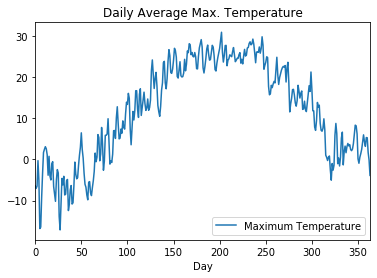

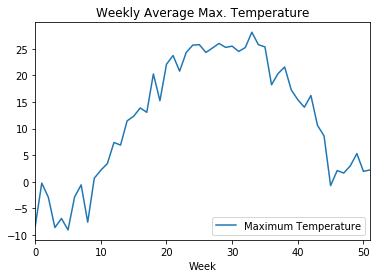

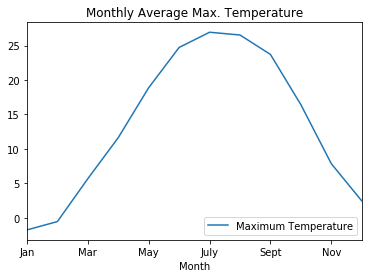

In [723]:
plt.figure()
daily.plot(kind='line', x='Day', y='Maximum Temperature')
plt.title("Daily Average Max. Temperature")
weekly.plot(kind='line', x='Week', y='Maximum Temperature')
plt.title("Weekly Average Max. Temperature")
monthly.plot(kind='line', x='Month', y='Maximum Temperature')
plt.title("Monthly Average Max. Temperature")
plt.show()

The following shows the plots of the daily, weekly and monthly average humidity. The daily and weekly plots are far too variable to use, however the monthly plot interestingly shows how temperature and humidity do seem infact inversely proportional.

With quite a large trough mainly during the warmer summer months, the relation is clear. 

Again however, the monthly plot seems to erdaicate the outliers, particularly the upper values this time.


<Figure size 432x288 with 0 Axes>

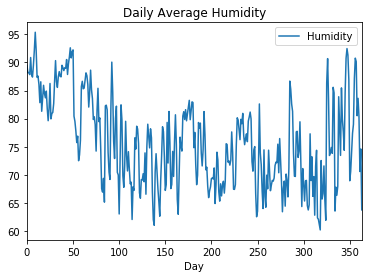

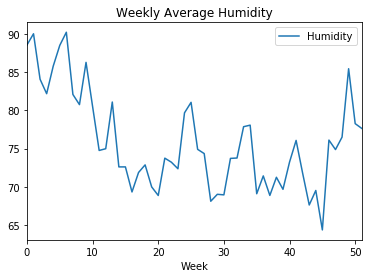

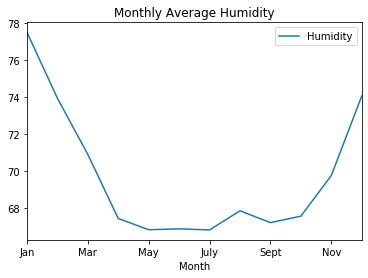

In [755]:
plt.figure()
daily.plot(kind='line', x='Day', y='Humidity')
plt.title("Daily Average Humidity")
weekly.plot(kind='line', x='Week', y='Humidity')
plt.title("Weekly Average Humidity")
monthly.plot(kind='line', x='Month', y='Humidity')
plt.title("Monthly Average Humidity")
plt.show()

**Scatter Plots**

The following scatter plot compares the average monthly maximum temperature and humidity. 

As mentioned above, the inversely proportional nature of the two pieces of data is clear.
However, below the trend is even more obvious.

It seems from the negative temperatures up to around 12 degrees celsius, the humidity drops at a steady rate. Above 12 degrees celsius the humidity looks to remain stationary.
This could be however an exponential drop, although it is difficult to establish.

The weekly average demonstrates that the monthly graph is very accurate and there are many outliers and unpredictable values possible to arise.


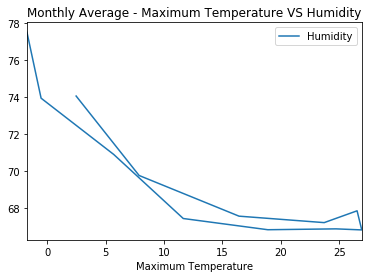

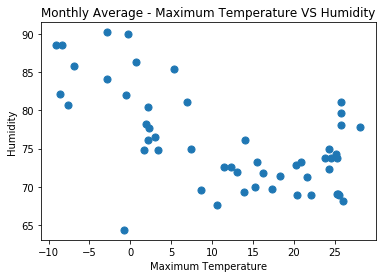

In [750]:
monthly.plot(kind='scatter', x='Maximum Temperature', y='Humidity', s=50)
plt.title("Monthly Average - Maximum Temperature VS Humidity")
weekly.plot(kind='scatter', x='Maximum Temperature', y='Humidity', s=50)
plt.title("Monthly Average - Maximum Temperature VS Humidity")
plt.show()


**Stacked Histogram**

The histogram below shows the distirbution of data for monthly humidity and maximum temperature.
Humidity values seem to spread from around 62 to 77 grams per cubic metre.
Maximum temperature spreads from about -2 to 30 degrees celsius.


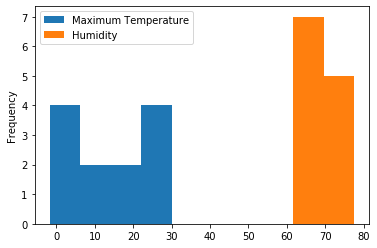

In [745]:
monthly.plot.hist(stacked=True)

### Final Manipulation, Exploration and Visualisation

**Temperature v Humidity**

In the following line graph, I compare temperature and humidity as a factor of time.
The line starts at the left most point in January and ends around the (2.5, 74) point in December.
This is clearer than what our scatter plot above displayed as it indicates the timing of the data.
The first five months (or first five points), seem exponential in nature as the temperature rises and humidity dips.
After July and the temperature starts to drop again, the humidity grows again seemingly exponetially until December.


Text(0.5, 1.0, 'Monthly Average - Maximum Temperature VS Humidity')

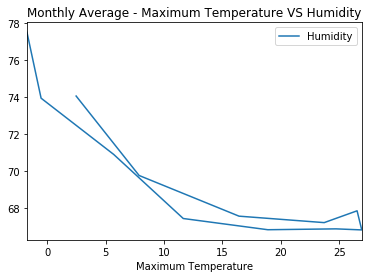

In [752]:
monthly.plot(kind='line', x='Maximum Temperature', y='Humidity')
plt.title("Monthly Average - Maximum Temperature VS Humidity")

**Test Data**

Having created a model using data over five years, 2014-2018, to test the efficiency of the model, the following code retrieves the data from the API for 2019 and the predicted compared to actual values will be compared.


In [753]:
# Same as in Task 3, makes a csv test file, retrieves the data from the API and only puts the needed data in the file
city = "2379574" # Location Number of Chicago
test_file = "weather-test.csv"
heading = ["Date","Maximum Temperature","Humidity"]
make_file(test_file, heading)

year = 2019 # Data only starts mid 2013
month = "1"
day = "1"
count = 1
# year < 2019
while year < 2020:  # Will count 2 days in 2019, 209 weeks total
    if int(month) < 10:
        month = "0" + month
    if int(day) < 10:
        day = "0" + day
    
    get_data(test_file, city, year, month, day)
    time = update_dates(year, month, day)
    year = time[0]
    month = time[1]
    day = time[2]
    count += 1
print("\nRaw data is collected \nCount = " + str(count))


Raw data is collected 
Count = 365


After the data is entered into the test file, the code will now read the data and sort it into a panda series.

In [756]:
test_data = open(test_file, "r") 
daily_test_data = pd.read_csv(test_data)
daily_test_data['Date'] = pd.to_datetime(daily_test_data['Date'])

print(daily_test_data[0:5])
test_data.close()

        Date  Maximum Temperature   Humidity
0 2019-01-01             0.572054  75.577465
1 2019-01-02            -2.321538  68.098592
2 2019-01-03             0.177641  65.845070
3 2019-01-04             3.361960  73.056338
4 2019-01-05             4.758545  75.802817


In [757]:
daily_test_data.isnull().sum()

Date                   0
Maximum Temperature    0
Humidity               0
dtype: int64

Again, no null values present.

In [784]:
daily_test_data.dtypes.value_counts()

float64           2
datetime64[ns]    1
dtype: int64

No strings or text present in the data that could manipulate the results.

The following code picks random dates and compares the predicted temperature and humidity of our model to the actual values.


In [781]:
import math
import numpy as np

randomDaysTestTemp = []
randomDaysTestHum = []

# Picks 200 random values between 0 and 364
for x in range(200):
    value = np.random.randint(0,364)
    
    # Predicted and actual values for each date are recorded
    predictT = daily["Maximum Temperature"][value]
    testT = daily_test_data["Maximum Temperature"][value]
    predictH = daily["Humidity"][value]
    testH = daily_test_data["Humidity"][value]
    week = value # The week number is recorded for sorting the plots later
    
    randomDaysTestTemp.append([week, predictT, testT, abs(predictT-testT)])
    randomDaysTestHum.append([week, predictH, testH, abs(predictH-testH)])
    
# The lists are put into dataframes for ease of analysis
randomTestTemp = pd.DataFrame(randomDaysTestTemp, columns=['Week', 'Predicted Temp.', 'Test Temp.', 'Difference'])
randomTestHum = pd.DataFrame(randomDaysTestHum, columns=['Week', 'Predicted Hum.', 'Test Hum.', 'Difference'])

print(randomTestTemp[0:10])
print("--------------------------------------------")
print(randomTestHum[0:10])

   Week  Predicted Temp.  Test Temp.  Difference
0   199        25.817812   33.789375    7.971563
1   297        17.876000    9.413125    8.462875
2    41       -10.542700   -0.643099    9.899601
3   219        24.529747   28.465000    3.935253
4    67         0.515804    2.562230    2.046426
5   148        20.871788   23.528732    2.656945
6    42        -6.220223    0.572407    6.792631
7    74        -2.648259    2.328521    4.976780
8    15         0.735304    1.079953    0.344649
9   281        15.629351   20.125986    4.496635
--------------------------------------------
   Week  Predicted Hum.  Test Hum.  Difference
0   199       67.839286  56.972222   10.867063
1   297       71.732143  62.472222    9.259921
2    41       89.054545  81.507042    7.547503
3   219       72.464286  50.194444   22.269841
4    67       82.053571  75.478873    6.574698
5   148       77.672727  66.450704   11.222023
6    42       88.964286  83.236111    5.728175
7    74       78.928571  62.741935   16.

**Plots**

The scatter plots below show the accuracy of the temperature model, the shape of the predicted and actual are very similar, as well as the outliers.


Text(0.5, 1.0, 'Random Predicted Temperatures')

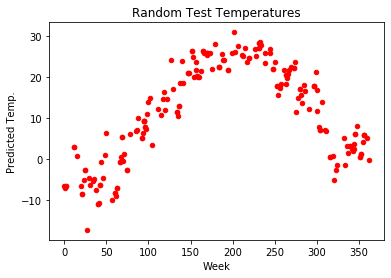

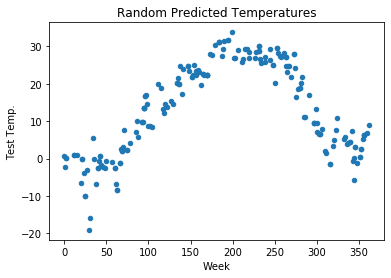

In [785]:
randomTestTemp.sort_values(by=['Week'])
randomTestTemp.plot(kind='scatter', x='Week', y='Predicted Temp.', color='r')
plt.title("Random Test Temperatures")
randomTestTemp.plot(kind='scatter', x='Week', y='Test Temp.')
plt.title("Random Predicted Temperatures")

The scatter plot for humidity however is very unpredictable, however, a slight U curve can be noticed but not enough to predict any values accurately. 

Text(0.5, 1.0, 'Random Predicted Humidities')

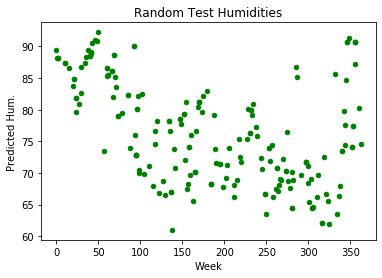

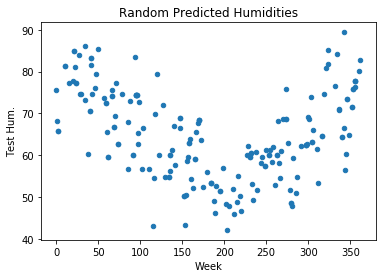

In [783]:
randomTestHum.sort_values(by=['Week'])
randomTestHum.plot(kind='scatter', x='Week', y='Predicted Hum.', color='g')
plt.title("Random Test Humidities")
randomTestHum.plot(kind='scatter', x='Week', y='Test Hum.')
plt.title("Random Predicted Humidities")

### Conclusion

Deeper analyse could definitely be undertaken on the subject and a further range of meterological parameters could be investigated.
Clearly, humidity does infact seem inversely proportional to temperature but not noticably enough by this data to confidently predict future values.
This is clear by the 2019 test, where the scatter plots do not align very much at all.
Although, from the test, it is evident that temperature could relatively be predicted by a model like this. The actual and predicted results are very similar, despite the fact that only 5 years were used to calculate this prediction model.